In [1]:
from spektral.layers import GCNConv, TAGConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import pandas as pd

In [2]:
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool, ChebConv, GlobalSumPool, GraphSageConv
from spektral.layers.pooling import TopKPool
from spektral.transforms.normalize_adj import NormalizeAdj
import pickle as pkl
import networkx as nx
import pdb
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from spektral.layers import GCNConv, GraphSageConv
from spektral.models.gcn import GCN
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from sklearn.preprocessing import MinMaxScaler

# Preprocess data
- Read the circuit files (.x, .y, and .graph)
- Normalize the circuit level features using Min Max Scalar for each circuit
- Generate the adjacency matrix from graph dictionary


In [3]:

batch_size = 3  # Batch size

import sys
from spektral.data import Dataset, Graph
# sys.path.append('../lib')
# from data_pre_processing import load_data
# sys.path.remove('../lib')

x_data = []
y_data = []

def load_data(circuit_name, path_to_data="data", normalize=False):
    """Load data."""
    names = ["x", "y", "graph"]
    objects = []
    for i in range(len(names)):
        with open(f"{path_to_data}/{circuit_name}.{names[i]}", "rb") as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding="latin1"))
            else:
                objects.append(pkl.load(f))

    x, y, graph = tuple(objects)
    
    x = np.array(x).astype("float32")
    for x_feat in x:
        x_data.append(x_feat)
        
    features = sp.csr_matrix(x).astype('float32')
    # adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph)).astype(int)
    g = nx.DiGraph()
    g.add_nodes_from(graph.keys())
    for k, v in graph.items():
      g.add_edges_from(([(k, t) for t in v]))
      g.add_edges_from([(k, k)])
    adj = nx.adjacency_matrix(g)
    labels = np.array(y).astype('float32').reshape((-1,1))
    for l in y:
        y_data.append(l)
    print(adj.shape)
    print(features.shape)
    return adj, features, labels
  
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels


def _preprocess_features(features):
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.0
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features



class CircuitDataset(Dataset):
    def read(self):
        circuits = []
        circs = ["adder.bench","arbiter.bench","c1355","c1908","c3540","c432","c499","c5315","c6288","c880","cavlc.bench","ctrl","dec.bench","i2c","int2float.bench","max.bench","multiplier.bench","priority.bench","router","sin.bench","voter.bench"]
        for circ in circs:
            A, X, labels = load_data(circ, 'data/output', normalize="")
            print(f"{circ}: {sum(labels)}, {len(labels)}")
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X.toarray())
            circuits.append(Graph(x=X, a=A, y=labels))

        return circuits




# Initialize dataset and split into train, test, and validation

In [4]:
dataset = CircuitDataset(transforms=[LayerPreprocess(TAGConv)])

# Parameters

F = dataset.n_node_features  # Dimension of node features
n_out = dataset.n_labels  # Dimension of the target

# Train/valid/test split
np.random.seed(42)
idxs = np.random.permutation(len(dataset))
split_va, split_te = int(0.8 * len(dataset)), int(0.9 * len(dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
print(idx_tr, idx_va, idx_te)
dataset_tr = dataset[idx_tr]
dataset_va = dataset[idx_va]
dataset_te = dataset[idx_te]
def load_tr_data(epochs=400):
    loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, node_level=True)
    loader_va = DisjointLoader(dataset_va, batch_size=batch_size, node_level=True)
    loader_te = DisjointLoader(dataset_te, batch_size=batch_size, node_level=True)
    return loader_tr, loader_va, loader_te

loader_tr, loader_va, loader_te = load_tr_data()


(4209, 4209)
(4209, 4)
adder.bench: [637.], 4209
(36352, 36352)
(36352, 4)
arbiter.bench: [3763.], 36352
(1355, 1355)
(1355, 4)
c1355: [192.], 1355
(1908, 1908)
(1908, 4)
c1908: [257.], 1908
(3540, 3540)
(3540, 4)
c3540: [406.], 3540
(432, 432)
(432, 4)
c432: [60.], 432
(499, 499)
(499, 4)
c499: [50.], 499
(5315, 5315)
(5315, 4)
c5315: [599.], 5315
(6288, 6288)
(6288, 4)
c6288: [846.], 6288
(880, 880)
(880, 4)
c880: [114.], 880
(2164, 2164)
(2164, 4)
cavlc.bench: [318.], 2164
(569, 569)
(569, 4)
ctrl: [92.], 569
(936, 936)
(936, 4)
dec.bench: [186.], 936
(4107, 4107)
(4107, 4)
i2c: [502.], 4107
(761, 761)
(761, 4)
int2float.bench: [80.], 761
(9996, 9996)
(9996, 4)
max.bench: [1040.], 9996
(89943, 89943)
(89943, 4)
multiplier.bench: [9294.], 89943
(3495, 3495)
(3495, 4)
priority.bench: [350.], 3495
(945, 945)
(945, 4)
router: [99.], 945
(16771, 16771)
(16771, 4)
sin.bench: [1723.], 16771
(50122, 50122)
(50122, 4)
voter.bench: [5012.], 50122
[ 0 17 15  1  8  5 11  3 18 16 13  2  9 20  4 

# Normalized Input Distribution

In [5]:
dataset_tr[0]

Graph(n_nodes=4209, n_node_features=4, n_edge_features=None, n_labels=1)

In [6]:
# for i, g in enumerate(dataset):
#     print(f"----------------{i}-----------------")
#     df_all_circ_data = pd.DataFrame(g.x, columns=['level', 'c0', 'c1', 'ob'])
#     df_all_circ_data['y'] = g.y
#     for col in ['level', 'c0', 'c1', 'ob']:
#         df_all_circ_data.hist(by='y', column=col, sharex=True, sharey=True)
#         plt.suptitle(col)
#         plt.show()

In [7]:
N = sum([ g.n_nodes for g in dataset.graphs ])
n_out = 1
N

240587

# Compute class weight for unbalanced labels

In [8]:
from sklearn.utils.class_weight import compute_class_weight

y_data = []
for data_tr in dataset_tr:
    y_data.append(data_tr.y)
y_data = np.vstack((y_data)).reshape((-1,))


def _compute_class_weight_dictionary(y):
    # helper for returning a dictionary instead of an array
    classes = np.unique(y).astype('float32')
    class_weight = compute_class_weight("balanced", classes, y)
    class_weight_dict = dict(zip(classes, class_weight))
    return class_weight_dict 

weights = _compute_class_weight_dictionary(np.vstack((y_data)).reshape((-1,)))
print(weights)

{0.0: 0.5594349389003626, 1.0: 4.706280087527352}


/Users/nikitaacharya/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [9]:
%load_ext tensorboard

# Topology Aware Graph Convolution Network Model (TAGConv)

In [10]:
from tensorflow.keras.metrics import sparse_categorical_accuracy, binary_accuracy, binary_crossentropy
from tensorflow.keras import activations
from tensorflow.keras import layers

channels = 256         # Number of channels in the first layer
dropout = 0.05         # Dropout rate for the features
l2_reg = 1e-4           # L2 regularization rate
learning_rate = 1e-5    # Learning rate
epochs = 500            # Number of training epochs
es_patience = 10    
patience = 100 # Patience for early stopping
# N = 

# Model definition
X_in = Input(shape=(F, ))
print("X_in: ", X_in.shape)
fltr_in = Input((None, ), sparse=True)
mask_in = Input((None, ))

use_bias = True
x = TAGConv(channels, K=10, aggregate="sum",
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv1")([X_in, fltr_in]) 
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x1 = TAGConv(256, k = 5, aggregate="mean",
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv2")([x, fltr_in])
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
# x = TAGConv(256, k = 5, aggregate="sum",
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="conv3")([x, fltr_in])
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
x = GraphSageConv(256, aggregate_op='sum',
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv3")([X_in, fltr_in])
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x2 = GraphSageConv(256, aggregate_op='sum',
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv4")([x, fltr_in])
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
# x = GraphSageConv(128, aggregate_op='sum',
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="conv5")([x, fltr_in])
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
# x = GraphSageConv(64, aggregate_op='sum',
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="conv6")([x, fltr_in])
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
# x = GraphSageConv(32, aggregate_op='sum',
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="conv7")([x, fltr_in])
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
# x = GraphSageConv(4, aggregate_op='sum',
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="conv8")([x, fltr_in])
concatted = tf.keras.layers.Concatenate()([x1, x2])

x = BatchNormalization()(concatted)
x = Dropout(dropout)(concatted)
x = GCNConv(n_out, activation='sigmoid',
                         n_input_channels=dataset.n_node_features, name="classification", use_bias=use_bias)([x, fltr_in])

model = Model(inputs=[X_in, fltr_in, mask_in], outputs=x)
optimizer = Adam(lr=learning_rate)

def masked_loss_and_accuracy(target, predictions):
    loss = binary_crossentropy(target, predictions)
    minimum = tf.math.minimum(tf.reduce_sum(tf.dtypes.cast(target == 0, tf.int32)), tf.reduce_sum(tf.dtypes.cast(target == 1, tf.int32)))
    zeroes_index = tf.random.shuffle(tf.where(target == 0)[:,0])
    ones_index = tf.random.shuffle(tf.where(target == 1)[:,0])
    loss_zeroes =  tf.reduce_mean(tf.gather(loss, zeroes_index))
    loss_ones = tf.reduce_mean(tf.gather(loss, ones_index))
    
    weight_for_0 = tf.cast((1 / tf.shape(zeroes_index)[0])*(tf.cast(tf.shape(target)[0], 'float64'))/2.0, 'float32')
    weight_for_1 = tf.cast((1 / tf.shape(ones_index)[0])*(tf.cast(tf.shape(target)[0], 'float64'))/2.0, 'float32')

    return (weight_for_0 * loss_zeroes * 0.6 +  weight_for_1 * loss_ones * 0.4)


model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              weighted_metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

import tempfile
tfcallback_dir = tempfile.TemporaryDirectory(suffix='tf', prefix='', dir=None).name
tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
        log_dir=tfcallback_dir,
        histogram_freq=1
)
# 
callback_GCN = [tbCallBack_GCN, EarlyStopping(patience=patience, restore_best_weights=True)]

X_in:  (None, 4)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
conv1 (TAGConv)                 (None, 256)          11520       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv3 (GraphSageConv)           (None, 256)          2304        input_1[0][0

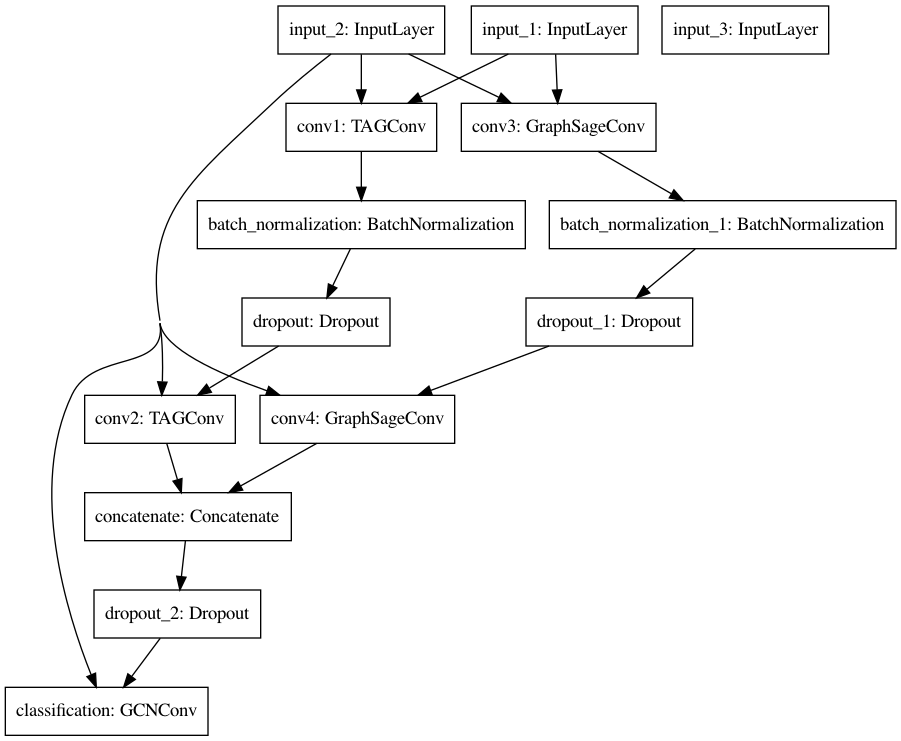

In [11]:
tf.keras.utils.plot_model(
    model,
    show_layer_names=True,
    rankdir="TB",
    dpi=96,
)

# Train the model

In [12]:
epochs = 150
loader_tr, loader_va, loader_te = load_tr_data(epochs)
# class_weight = {0: 0.11, 1: 0.89}
history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    class_weight=weights,
    callbacks=callback_GCN
)

Epoch 1/150
6/6 [==============================] - 14s 2s/step - loss: 0.7511 - acc: 0.5974 - precision: 0.5603 - recall: 0.8799 - val_loss: 0.7906 - val_acc: 0.2043 - val_precision: 0.1335 - val_recall: 1.0000
Epoch 2/150
6/6 [==============================] - 16s 621ms/step - loss: 0.7509 - acc: 0.5740 - precision: 0.5424 - recall: 0.9101 - val_loss: 0.7917 - val_acc: 0.2548 - val_precision: 0.1413 - val_recall: 1.0000
Epoch 3/150
6/6 [==============================] - 10s 1s/step - loss: 0.7232 - acc: 0.6974 - precision: 0.6321 - recall: 0.9401 - val_loss: 0.7929 - val_acc: 0.2829 - val_precision: 0.1460 - val_recall: 1.0000
Epoch 4/150
6/6 [==============================] - 8s 2s/step - loss: 0.7138 - acc: 0.6806 - precision: 0.6169 - recall: 0.9593 - val_loss: 0.7933 - val_acc: 0.3181 - val_precision: 0.1524 - val_recall: 1.0000
Epoch 5/150
6/6 [==============================] - 8s 1s/step - loss: 0.6939 - acc: 0.7273 - precision: 0.6568 - recall: 0.9672 - val_loss: 0.7940 - val_a

Epoch 40/150
6/6 [==============================] - 10s 2s/step - loss: 0.6170 - acc: 0.7243 - precision: 0.6626 - recall: 0.9258 - val_loss: 0.6859 - val_acc: 0.7280 - val_precision: 0.3087 - val_recall: 0.9826
Epoch 41/150
6/6 [==============================] - 9s 2s/step - loss: 0.5786 - acc: 0.7810 - precision: 0.7149 - recall: 0.9496 - val_loss: 0.6808 - val_acc: 0.7320 - val_precision: 0.3116 - val_recall: 0.9804
Epoch 42/150
6/6 [==============================] - 7s 794ms/step - loss: 0.5825 - acc: 0.7860 - precision: 0.7156 - recall: 0.9485 - val_loss: 0.6754 - val_acc: 0.7353 - val_precision: 0.3141 - val_recall: 0.9793
Epoch 43/150
6/6 [==============================] - 8s 1s/step - loss: 0.5805 - acc: 0.7980 - precision: 0.7302 - recall: 0.9540 - val_loss: 0.6716 - val_acc: 0.7367 - val_precision: 0.3153 - val_recall: 0.9793
Epoch 44/150
6/6 [==============================] - 8s 1s/step - loss: 0.6061 - acc: 0.7589 - precision: 0.6912 - recall: 0.9334 - val_loss: 0.6675 - va

Epoch 79/150
6/6 [==============================] - 10s 589ms/step - loss: 0.5716 - acc: 0.7516 - precision: 0.6714 - recall: 0.9809 - val_loss: 0.5273 - val_acc: 0.7806 - val_precision: 0.3544 - val_recall: 0.9607
Epoch 80/150
6/6 [==============================] - 7s 1s/step - loss: 0.5462 - acc: 0.7968 - precision: 0.7240 - recall: 0.9576 - val_loss: 0.5223 - val_acc: 0.7835 - val_precision: 0.3569 - val_recall: 0.9542
Epoch 81/150
6/6 [==============================] - 9s 2s/step - loss: 0.5745 - acc: 0.7812 - precision: 0.7195 - recall: 0.9431 - val_loss: 0.5207 - val_acc: 0.7829 - val_precision: 0.3561 - val_recall: 0.9542
Epoch 82/150
6/6 [==============================] - 7s 1s/step - loss: 0.5676 - acc: 0.7842 - precision: 0.7289 - recall: 0.9022 - val_loss: 0.5188 - val_acc: 0.7833 - val_precision: 0.3563 - val_recall: 0.9520
Epoch 83/150
6/6 [==============================] - 7s 1s/step - loss: 0.5456 - acc: 0.8013 - precision: 0.7326 - recall: 0.9464 - val_loss: 0.5147 - va

Epoch 118/150
6/6 [==============================] - 8s 1s/step - loss: 0.5004 - acc: 0.8333 - precision: 0.7716 - recall: 0.9500 - val_loss: 0.4423 - val_acc: 0.8119 - val_precision: 0.3870 - val_recall: 0.9149
Epoch 119/150
6/6 [==============================] - 7s 1s/step - loss: 0.4846 - acc: 0.8563 - precision: 0.8016 - recall: 0.9628 - val_loss: 0.4413 - val_acc: 0.8123 - val_precision: 0.3873 - val_recall: 0.9128
Epoch 120/150
6/6 [==============================] - 7s 1s/step - loss: 0.5009 - acc: 0.8189 - precision: 0.7570 - recall: 0.9433 - val_loss: 0.4378 - val_acc: 0.8147 - val_precision: 0.3903 - val_recall: 0.9095
Epoch 121/150
6/6 [==============================] - 7s 749ms/step - loss: 0.5039 - acc: 0.8184 - precision: 0.7485 - recall: 0.9634 - val_loss: 0.4344 - val_acc: 0.8179 - val_precision: 0.3945 - val_recall: 0.9073
Epoch 122/150
6/6 [==============================] - 7s 1s/step - loss: 0.5232 - acc: 0.8383 - precision: 0.7784 - recall: 0.9457 - val_loss: 0.4317 

In [13]:
import os
import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorboard.plugins import projector

In [14]:
%tensorboard --logdir {tfcallback_dir}

In [15]:
model_loss = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done. Test loss: {}".format(model_loss))

1/1 [==============================] - 0s 229ms/step - loss: 0.3452 - acc: 0.8896 - precision: 0.4141 - recall: 0.1781
Done. Test loss: [0.3452495336532593, 0.8896344900131226, 0.41405269503593445, 0.17808958888053894]


# Model prediction metrics

In [16]:
from sklearn.metrics import classification_report
print(len(dataset_te))
for test_data in dataset_te:
    X_te = test_data.x
    A_te = test_data.a
    y_te = test_data.y

    y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
    report = classification_report(y_te, (y_pred >= 0.5).astype(int))
    print('GCN Classification Report: \n {}'.format(report))

3
GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.45      0.62       449
         1.0       0.17      1.00      0.29        50

    accuracy                           0.50       499
   macro avg       0.58      0.72      0.45       499
weighted avg       0.92      0.50      0.58       499

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.91      1.00      0.95     15048
         1.0       1.00      0.12      0.21      1723

    accuracy                           0.91     16771
   macro avg       0.95      0.56      0.58     16771
weighted avg       0.92      0.91      0.88     16771

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.68      0.81       681
         1.0       0.27      1.00      0.42        80

    accuracy                           0.71       761
   macro avg       0.63      0.84      

In [17]:
from sklearn.metrics import classification_report
print(len(dataset_va))
for test_data in dataset_va:
    X_te = test_data.x
    A_te = test_data.a
    y_te = test_data.y

    y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
    report = classification_report(y_te, (y_pred >= 0.5).astype(int))
    print('GCN Classification Report: \n {}'.format(report))

2
GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.42      0.59      1846
         1.0       0.23      1.00      0.37       318

    accuracy                           0.50      2164
   macro avg       0.61      0.71      0.48      2164
weighted avg       0.89      0.50      0.56      2164

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      4716
         1.0       0.71      0.77      0.74       599

    accuracy                           0.94      5315
   macro avg       0.84      0.86      0.85      5315
weighted avg       0.94      0.94      0.94      5315



In [18]:
from sklearn.metrics import classification_report
print(len(dataset_tr))
for test_data in dataset_tr:
    X_te = test_data.x
    A_te = test_data.a
    y_te = test_data.y

    y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
    report = classification_report(y_te, (y_pred >= 0.5).astype(int))
    print('GCN Classification Report: \n {}'.format(report))

16
GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       766
         1.0       0.73      0.60      0.66       114

    accuracy                           0.92       880
   macro avg       0.84      0.78      0.81       880
weighted avg       0.91      0.92      0.92       880

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.65      0.79      5442
         1.0       0.31      1.00      0.47       846

    accuracy                           0.70      6288
   macro avg       0.66      0.83      0.63      6288
weighted avg       0.91      0.70      0.75      6288

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.94      0.43      0.59      1163
         1.0       0.20      0.83      0.32       192

    accuracy                           0.49      1355
   macro avg       0.57      0.63     

# Model layers output using TSNE

In [19]:
from sklearn.manifold import TSNE
test_data = dataset_te[1]
X_te = test_data.x
A_te = test_data.a
y_te = test_data.y

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X_te,A_te, A_te],batch_size=X_te.shape[0])


In [20]:
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

num_classes = 2
def plot_tSNE(labels_encoded,x_tsne):
    color_map = labels_encoded
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl, alpha=0.5)
    plt.legend()
    plt.show()

13


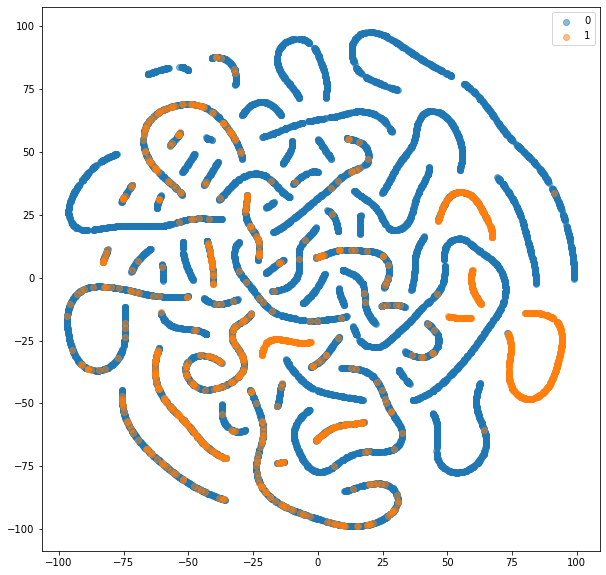

In [22]:
for i, layer in enumerate(model.layers):
#     if isinstance(layer, TAGConv) or isinstance(layer, GraphSageConv):
    if isinstance(layer, GCNConv):
        print(i)
        x_tsne17 = TSNE(n_components=2).fit_transform(activations[i]) 
        plot_tSNE(y_te,x_tsne17)

In [28]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()
    
    

In [29]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    precision = cnf_matrix[1,1]/cnf_matrix[:,1].sum()
    recall = cnf_matrix[1,1]/cnf_matrix[1,:].sum()
    print('precision:', precision)
    print('recall:', recall)
    if normalize:
#         cnf_matrix = confusion_matrix
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")
   
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

3
precision: 1.0
recall: 0.16722408026755853
Confusion matrix, without normalization


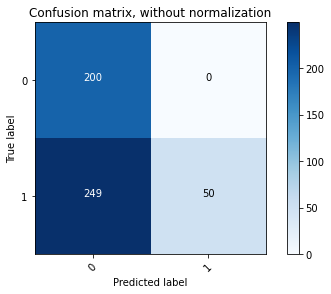

DNN Classification Report: 
 None
precision: 0.11607661056297155
recall: 1.0
Confusion matrix, without normalization


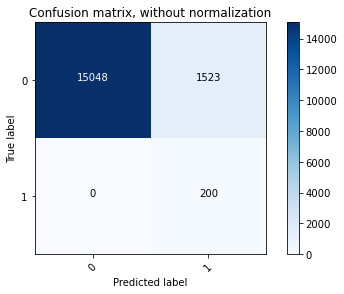

DNN Classification Report: 
 None
precision: 1.0
recall: 0.2684563758389262
Confusion matrix, without normalization


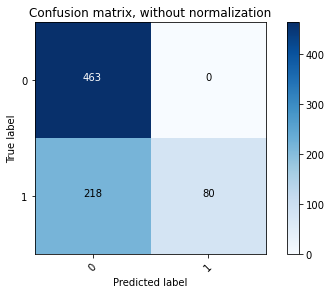

DNN Classification Report: 
 None


In [32]:
from sklearn.metrics import classification_report
import itertools

print(len(dataset_te))
class_names = ['0', '1']
for test_data in dataset_te:
    X_te = test_data.x
    A_te = test_data.a
    y_te = test_data.y

    y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
    report = plot_confusion_matrix(y_te, (y_pred >= 0.5).astype(int))
    print('DNN Classification Report: \n {}'.format(report))